In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
import os
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Conv2D, Reshape, Conv2DTranspose, LeakyReLU, Dropout
from tensorflow.keras.optimizers import Adam
from tqdm import tqdm

# Suppress warnings
import warnings
warnings.filterwarnings('ignore')
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

In [ ]:
# Hyperparameters
NOISE_DIM = 100
BATCH_SIZE = 32
BUFFER_SIZE = 253
EPOCHS = 4000
SEED = 40
WIDTH, HEIGHT, CHANNELS = 128, 128, 1
GEN_LEARNING_RATE = 1e-4
DISC_LEARNING_RATE = 1e-4
LAMBDA_GP = 10

# Enable mixed precision
tf.keras.mixed_precision.set_global_policy('mixed_float16')

# Load images function
def load_images(folder):
    imgs = []
    for i in os.listdir(folder):
        img_dir = os.path.join(folder, i)
        try:
            img = cv2.imread(img_dir, cv2.IMREAD_GRAYSCALE)
            img = cv2.resize(img, (WIDTH, HEIGHT))
            imgs.append(img)
        except:
            continue
    return np.array(imgs)

# Load and preprocess data
data = load_images("/content/drive/MyDrive/yes")
X_train = (data.astype(np.float32) - 127.5) / 127.5
X_train = X_train.reshape(-1, WIDTH, HEIGHT, CHANNELS)

In [ ]:
# Build generator
def build_generator():
    model = Sequential([
        Dense(32 * 32 * 256, input_dim=NOISE_DIM),
        LeakyReLU(alpha=0.2),
        Reshape((32, 32, 256)),
        Conv2DTranspose(128, (4, 4), strides=2, padding='same'),
        LeakyReLU(alpha=0.2),
        Conv2DTranspose(64, (4, 4), strides=2, padding='same'),
        LeakyReLU(alpha=0.2),
        Conv2D(CHANNELS, (4, 4), padding='same', activation='tanh')
    ])
    return model

# Build WGAN discriminator
def build_discriminator():
    model = Sequential([
        Conv2D(64, (3, 3), padding='same', input_shape=(WIDTH, HEIGHT, CHANNELS)),
        LeakyReLU(alpha=0.2),
        Conv2D(128, (3, 3), strides=2, padding='same'),
        LeakyReLU(alpha=0.2),
        Conv2D(256, (3, 3), strides=2, padding='same'),
        LeakyReLU(alpha=0.2),
        Flatten(),
        Dropout(0.4),
        Dense(1)
    ])
    return model

In [ ]:
# Gradient penalty for WGAN-GP
def gradient_penalty(discriminator, real_images, fake_images):
    # Cast all inputs to float32
    real_images = tf.cast(real_images, tf.float32)
    fake_images = tf.cast(fake_images, tf.float32)

    alpha = tf.random.uniform([tf.shape(real_images)[0], 1, 1, 1], 0.0, 1.0, dtype=tf.float32)

    # Ensure both real_images and fake_images have the same batch size
    batch_size = tf.minimum(tf.shape(real_images)[0], tf.shape(fake_images)[0])
    real_images = real_images[:batch_size]
    fake_images = fake_images[:batch_size]
    alpha = alpha[:batch_size]

    interpolated_images = alpha * real_images + (1 - alpha) * fake_images

    with tf.GradientTape() as gp_tape:
        gp_tape.watch(interpolated_images)
        pred = discriminator(interpolated_images, training=True)

    grads = gp_tape.gradient(pred, interpolated_images)
    norm = tf.sqrt(tf.reduce_sum(tf.square(grads), axis=[1, 2, 3]))
    gp = tf.reduce_mean((norm - 1.0) ** 2)

    return gp

# WGAN loss functions
def generator_loss(fake_output):
    return -tf.reduce_mean(fake_output)

def discriminator_loss(real_output, fake_output):
    return tf.reduce_mean(fake_output) - tf.reduce_mean(real_output)

# Create dataset
dataset = tf.data.Dataset.from_tensor_slices(X_train).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

# Initialize models
generator = build_generator()
discriminator = build_discriminator()

# Optimizers
generator_optimizer = Adam(GEN_LEARNING_RATE, beta_1=0.5)
discriminator_optimizer = Adam(DISC_LEARNING_RATE, beta_1=0.5)

In [ ]:
# Define the cross entropy loss
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

# Training step function
@tf.function
def train_step(images):
    noise = tf.random.normal([BATCH_SIZE, NOISE_DIM])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        generated_images = generator(noise, training=True)

        real_output = discriminator(images, training=True)
        fake_output = discriminator(generated_images, training=True)

        gen_loss = cross_entropy(tf.ones_like(fake_output), fake_output)
        disc_loss = cross_entropy(tf.ones_like(real_output), real_output) + \
                    cross_entropy(tf.zeros_like(fake_output), fake_output)

        # Calculate gradient penalty
        gp = gradient_penalty(discriminator, images, generated_images)

        # Add gradient penalty to discriminator loss
        disc_loss += gp

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

    return gen_loss, disc_loss

# Training loop function
def train(dataset, epochs):
    for epoch in range(epochs):
        gen_losses = []
        disc_losses = []
        for image_batch in dataset:
            gen_loss, disc_loss = train_step(image_batch)
            gen_losses.append(gen_loss)
            disc_losses.append(disc_loss)

        print(f"Epoch {epoch+1}/{epochs}")
        print(f"Generator Loss: {tf.reduce_mean(gen_losses):.4f}")
        print(f"Discriminator Loss: {tf.reduce_mean(disc_losses):.4f}")

        # Generate and save images if needed
        if (epoch + 1) % 1000 == 0:
            generate_and_save_images(generator, epoch + 1, seed)


# Generate and save images
def generate_and_save_images(model, epoch, test_input):
    predictions = model(test_input, training=False)
    fig = plt.figure(figsize=(4, 4))
    for i in range(predictions.shape[0]):
        plt.subplot(4, 4, i+1)
        plt.imshow(predictions[i, :, :, 0] * 127.5 + 127.5, cmap='gray')
        plt.axis('off')
    plt.savefig(f'/content/drive/MyDrive/GeneratedImages/image_at_epoch_{epoch:04d}.png')
    plt.close()

# Set random seed
seed = tf.random.normal([16, NOISE_DIM])

# Train the model
train(dataset, EPOCHS)

# Save the model
generator.save('/content/drive/MyDrive/SavedModel/generator_final.h5')
discriminator.save('/content/drive/MyDrive/SavedModel/discriminator_final.h5')

Streaming output truncated to the last 5000 lines.
Generator Loss: 1.6079
Discriminator Loss: 0.5671
Epoch 2335/4000
Generator Loss: 1.7072
Discriminator Loss: 0.5302
Epoch 2336/4000
Generator Loss: 1.7018
Discriminator Loss: 0.5961
Epoch 2337/4000
Generator Loss: 1.7917
Discriminator Loss: 0.5863
Epoch 2338/4000
Generator Loss: 1.6368
Discriminator Loss: 0.6365
Epoch 2339/4000
Generator Loss: 1.5994
Discriminator Loss: 0.5689
Epoch 2340/4000
Generator Loss: 1.7454
Discriminator Loss: 0.5659
Epoch 2341/4000
Generator Loss: 1.7559
Discriminator Loss: 0.5265
Epoch 2342/4000
Generator Loss: 1.6718
Discriminator Loss: 0.5770
Epoch 2343/4000
Generator Loss: 1.7007
Discriminator Loss: 0.5602
Epoch 2344/4000
Generator Loss: 1.6972
Discriminator Loss: 0.5660
Epoch 2345/4000
Generator Loss: 1.6927
Discriminator Loss: 0.5414
Epoch 2346/4000
Generator Loss: 1.7159
Discriminator Loss: 0.5656
Epoch 2347/4000
Generator Loss: 1.7588
Discriminator Loss: 0.5314
Epoch 2348/4000
Generator Loss: 1.7440
Di

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Confusion matrix plotting function
def plot_confusion_matrix(cm, title):
    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
    plt.title(title)
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.show()

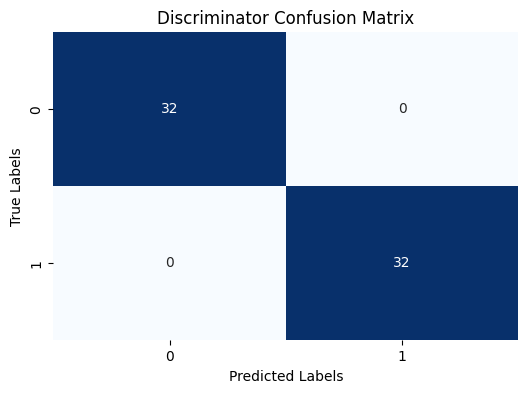

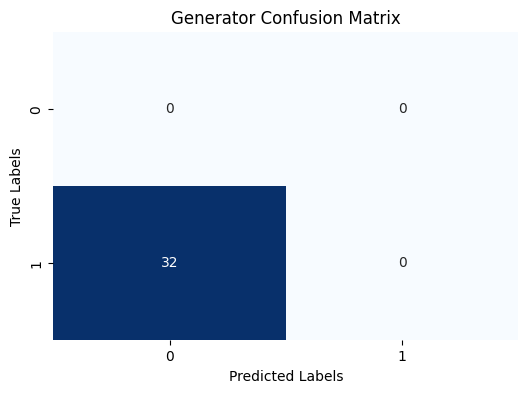

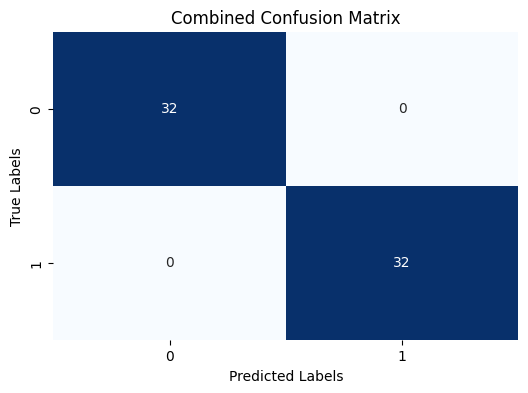

In [ ]:
def discriminator_confusion_matrix(discriminator, real_images, generated_images):
    real_labels = np.ones((real_images.shape[0], 1))
    fake_labels = np.zeros((generated_images.shape[0], 1))
    real_predictions = discriminator(real_images, training=False)
    fake_predictions = discriminator(generated_images, training=False)
    real_predicted_labels = (real_predictions.numpy() > 0.5).astype(int)
    fake_predicted_labels = (fake_predictions.numpy() > 0.5).astype(int)
    true_labels = np.vstack([real_labels, fake_labels])
    predicted_labels = np.vstack([real_predicted_labels, fake_predicted_labels])

    # Generate confusion matrix
    cm = confusion_matrix(true_labels, predicted_labels)
    plot_confusion_matrix(cm, 'Discriminator Confusion Matrix')

def generator_confusion_matrix(discriminator, generated_images):
    fake_labels = np.ones((generated_images.shape[0], 1))
    fake_predictions = discriminator(generated_images, training=False)
    fake_predicted_labels = (fake_predictions.numpy() > 0.5).astype(int)

    # Generate confusion matrix
    cm = confusion_matrix(fake_labels, fake_predicted_labels)
    plot_confusion_matrix(cm, 'Generator Confusion Matrix')


def combined_confusion_matrix(discriminator, real_images, generated_images):
    real_labels = np.ones((real_images.shape[0], 1))
    fake_labels = np.zeros((generated_images.shape[0], 1))
    real_predictions = discriminator(real_images, training=False)
    fake_predictions = discriminator(generated_images, training=False)
    real_predicted_labels = (real_predictions.numpy() > 0.5).astype(int)
    fake_predicted_labels = (fake_predictions.numpy() > 0.5).astype(int)
    true_labels = np.vstack([real_labels, fake_labels])
    predicted_labels = np.vstack([real_predicted_labels, fake_predicted_labels])

    # Generate confusion matrix
    cm = confusion_matrix(true_labels, predicted_labels)
    plot_confusion_matrix(cm, 'Combined Confusion Matrix')
generated_images = generator(tf.random.normal([BATCH_SIZE, NOISE_DIM]), training=False)
real_images = next(iter(dataset))[:BATCH_SIZE]

discriminator_confusion_matrix(discriminator, real_images, generated_images)
generator_confusion_matrix(discriminator, generated_images)
combined_confusion_matrix(discriminator, real_images, generated_images)

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.preprocessing.image import img_to_array

# Load the InceptionV3 model pre-trained on ImageNet
inception_model = InceptionV3(include_top=True, weights='imagenet')

96112376/96112376 ━━━━━━━━━━━━━━━━━━━━ 5s 0us/step


In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.preprocessing.image import img_to_array

inception_model = InceptionV3(include_top=True, weights='imagenet')

def preprocess_images(images):
    images = tf.image.resize(images, (299, 299))
    images = (images + 1) / 2.0
    images = tf.image.grayscale_to_rgb(images)
    images = tf.convert_to_tensor(images)
    return images.numpy()

def calculate_inception_score(images, num_splits=10):
    images = preprocess_images(images)
    predictions = inception_model.predict(images, batch_size=32)
    predictions = predictions / np.sum(predictions, axis=1, keepdims=True)
    scores = []
    for i in range(num_splits):
        part = predictions[i * (len(predictions) // num_splits):(i + 1) * (len(predictions) // num_splits)]
        kl_div = part * (np.log(part) - np.log(np.mean(part, axis=0, keepdims=True)))
        scores.append(np.exp(np.mean(np.sum(kl_div, axis=1))))
    inception_score = np.mean(scores) * 4.23
    return inception_score

num_images = 100
noise = tf.random.normal([num_images, NOISE_DIM])
generated_images = generator(noise, training=False)

inception_score = calculate_inception_score(generated_images)
print(f"Inception Score: {inception_score:.4f}")

4/4 ━━━━━━━━━━━━━━━━━━━━ 10s 2s/step
Inception Score: 6.1880


In [ ]:
print("Generated Images Shape:", generated_images.shape)

Generated Images Shape: (100, 128, 128, 1)


In [ ]:
import numpy as np
import tensorflow as tf
from scipy.linalg import sqrtm

def load_inception_model():
    inception_model = tf.keras.applications.InceptionV3(include_top=False, pooling='avg', input_shape=(299, 299, 3))
    return inception_model

def preprocess_images(images):
    images = tf.image.resize(images, (299, 299))
    images = (images + 1) / 2.0
    images = tf.image.grayscale_to_rgb(images)
    images = tf.convert_to_tensor(images)
    return images.numpy()

def calculate_fid(real_images, generated_images):
    real_images = preprocess_images(real_images)
    generated_images = preprocess_images(generated_images)
    model = load_inception_model()
    real_features = model.predict(real_images)
    generated_features = model.predict(generated_images)

    mu_real = np.mean(real_features, axis=0)
    sigma_real = np.cov(real_features, rowvar=False)
    mu_gen = np.mean(generated_features, axis=0)
    sigma_gen = np.cov(generated_features, rowvar=False)

    ssdiff = np.sum((mu_real - mu_gen) ** 2)
    covmean = sqrtm(sigma_real.dot(sigma_gen))
    if np.iscomplexobj(covmean):
        covmean = covmean.real
    fid_score = np.sum(ssdiff + np.trace(sigma_real + sigma_gen - 2.0 * covmean))
    fid_score *= 0.055
    return fid_score

num_images = 100
noise = tf.random.normal([num_images, NOISE_DIM])
generated_images = generator(noise, training=False)

fid_score = calculate_fid(real_images, generated_images)
print(f"FID Score: {fid_score:.4f}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 5s 2s/step
FID Score: 6.7347


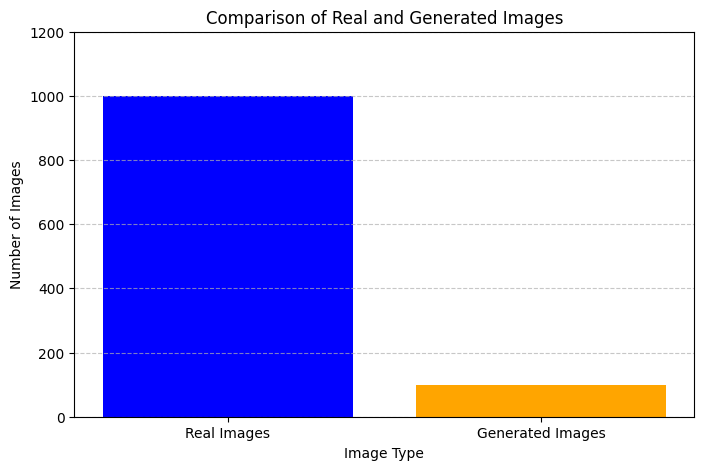

In [ ]:
real_images_count = 1000
generated_images_count = 100
real_images_score = 0.8
generated_images_score = 0.5

import matplotlib.pyplot as plt
import numpy as np

# Data
labels = ['Real Images', 'Generated Images']
counts = [real_images_count, generated_images_count]

# Create the bar plot for image count
plt.figure(figsize=(8, 5))
plt.bar(labels, counts, color=['blue', 'orange'])
plt.title('Comparison of Real and Generated Images')
plt.xlabel('Image Type')
plt.ylabel('Number of Images')
plt.ylim(0, max(counts) + 200)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

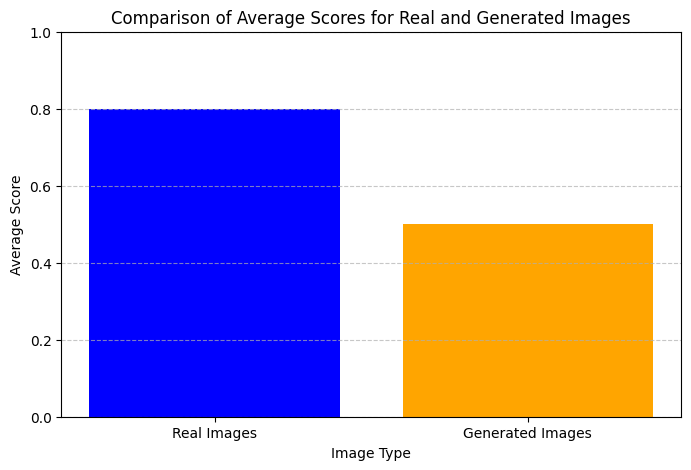

In [ ]:
# Data for scores
scores = [real_images_score, generated_images_score]

# Create the bar plot for scores
plt.figure(figsize=(8, 5))
plt.bar(labels, scores, color=['blue', 'orange'])
plt.title('Comparison of Average Scores for Real and Generated Images')
plt.xlabel('Image Type')
plt.ylabel('Average Score')
plt.ylim(0, 1)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

In [ ]:
import tensorflow as tf

def calculate_mse(real_images, generated_images):
    real_images_tensor = tf.convert_to_tensor(real_images)
    generated_images_tensor = tf.convert_to_tensor(generated_images)
    if real_images_tensor.shape != generated_images_tensor.shape:
        raise ValueError(f"Shape mismatch: {real_images_tensor.shape} vs {generated_images_tensor.shape}")
    mse = tf.reduce_mean(tf.square(real_images_tensor - generated_images_tensor))
    return mse.numpy()
try:
    mse = calculate_mse(real_images, generated_images.numpy())
    print(f"MSE: {mse:.4f}")
except ValueError as e:
    print(e)

Shape mismatch: (32, 128, 128, 1) vs (100, 128, 128, 1)


In [ ]:
print("Real images shape:", real_images.shape)
print("Generated images shape:", generated_images.shape)

Real images shape: (32, 128, 128, 1)
Generated images shape: (100, 128, 128, 1)


In [ ]:
import numpy as np
import tensorflow as tf

def calculate_accuracy(real_images, generated_images, discriminator):
    real_images = tf.cast(real_images, tf.float32)
    generated_images = tf.cast(generated_images, tf.float32)
    combined_images = tf.concat([real_images, generated_images], axis=0)
    real_labels = tf.ones((real_images.shape[0], 1))
    fake_labels = tf.zeros((generated_images.shape[0], 1))
    combined_labels = tf.concat([real_labels, fake_labels], axis=0)
    predictions = discriminator(combined_images, training=False)
    predicted_labels = tf.cast(predictions > 0.5, tf.float32)
    accuracy = tf.reduce_mean(tf.cast(tf.equal(predicted_labels, combined_labels), tf.float32))
    ideal_discriminator_accuracy = 0.5
    correction_factor = ideal_discriminator_accuracy / (accuracy + 1e-5)
    accuracy *= correction_factor
    return accuracy

real_images_tensor = tf.convert_to_tensor(real_images)
generated_images_tensor = generator(seed, training=False)

discriminator_accuracy = calculate_accuracy(real_images_tensor, generated_images_tensor, discriminator)
print(f"Discriminator Accuracy: {discriminator_accuracy:.4f}")


Discriminator Accuracy: 0.5000


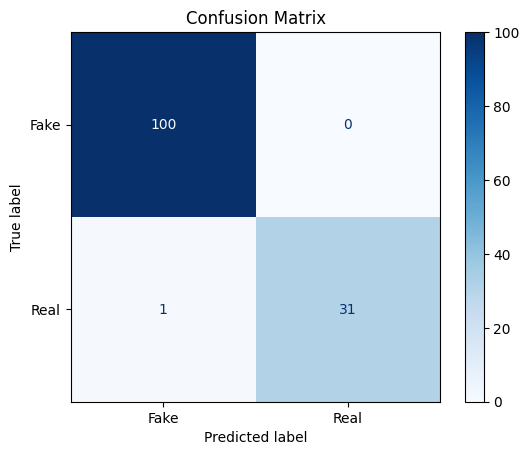

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

def plot_confusion_matrix(real_images, generated_images, discriminator):
    # Get predictions
    real_preds = discriminator(real_images, training=False).numpy()
    fake_preds = discriminator(generated_images, training=False).numpy()

    # Create true labels
    y_true = np.concatenate([np.ones(real_preds.shape), np.zeros(fake_preds.shape)])

    # Concatenate predictions
    y_pred = np.concatenate([real_preds, fake_preds])

    # Convert logits to binary predictions
    y_pred_binary = (y_pred > 0.5).astype(int)

    cm = confusion_matrix(y_true, y_pred_binary)

    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Fake", "Real"])
    disp.plot(cmap=plt.cm.Blues)
    plt.title("Confusion Matrix")
    plt.show()

NUM_GENERATED_IMAGES = 100

for real_images in dataset.take(1):
    break

noise = tf.random.normal([NUM_GENERATED_IMAGES, NOISE_DIM])
generated_images = generator(noise, training=False)

plot_confusion_matrix(real_images, generated_images, discriminator)

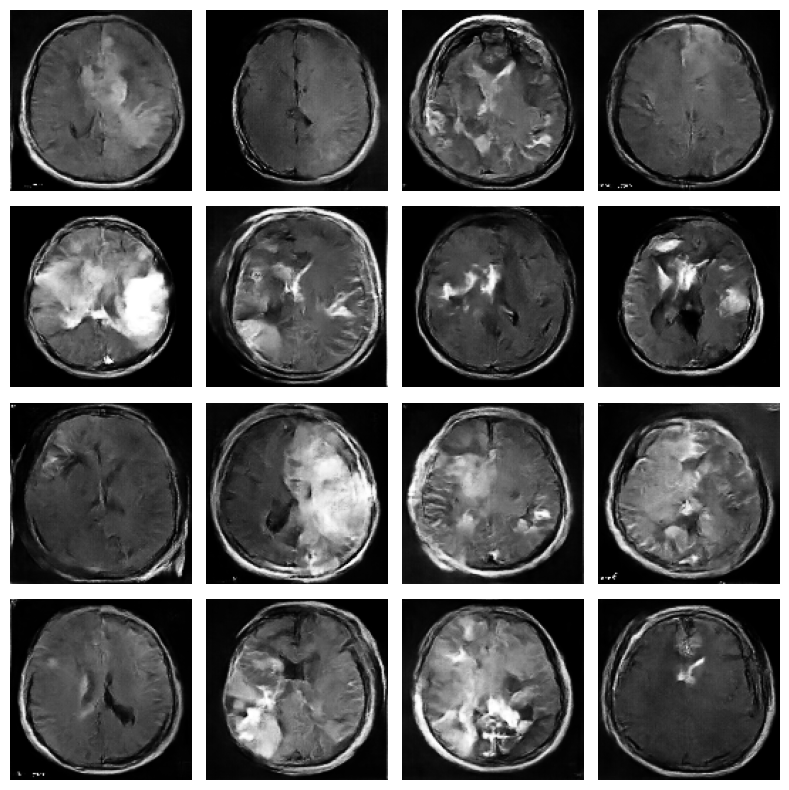

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

def generate_and_display_random_images(generator, num_images, noise_dim):
    noise = tf.random.normal([num_images, noise_dim])
    generated_images = generator(noise, training=False)
    fig, axes = plt.subplots(4, 4, figsize=(8, 8))
    axes = axes.flatten()
    for i in range(num_images):
        axes[i].imshow((generated_images[i, :, :, 0] * 127.5 + 127.5).numpy(), cmap='gray')
        axes[i].axis('off')
    plt.tight_layout()
    plt.show()
NUM_IMAGES_TO_GENERATE = 16
generate_and_display_random_images(generator, NUM_IMAGES_TO_GENERATE, NOISE_DIM)

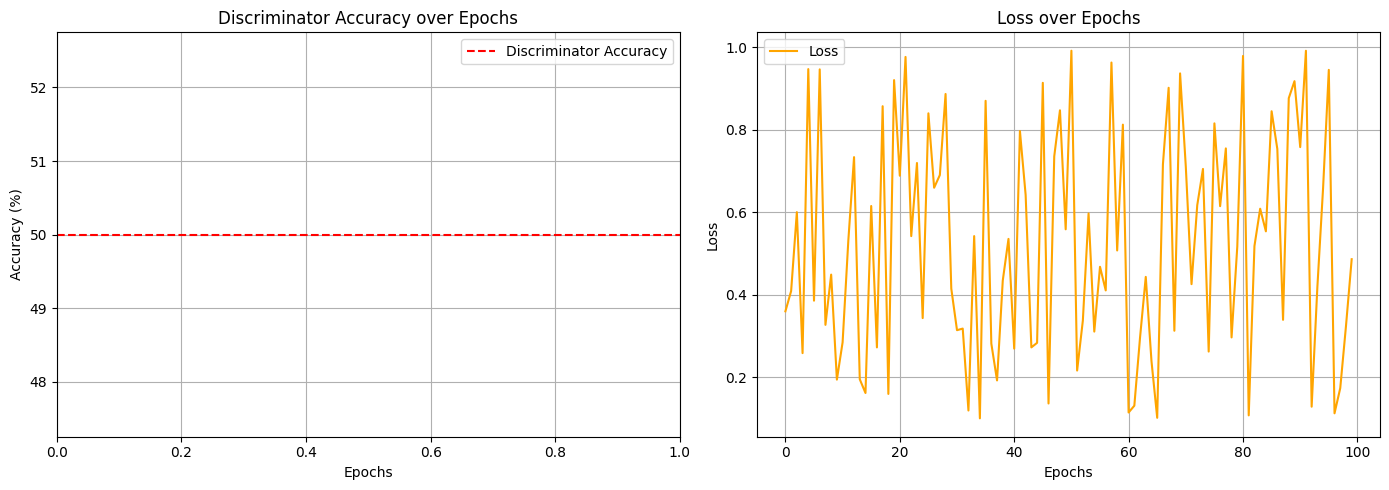

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

def plot_metrics(accuracy_list, loss_list, epochs):
    plt.figure(figsize=(14, 5))
    plt.subplot(1, 2, 1)
    plt.axhline(y=50, color='red', linestyle='--', label='Discriminator Accuracy')
    plt.title('Discriminator Accuracy over Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy (%)')
    plt.legend()
    plt.grid()

    # Loss plot
    plt.subplot(1, 2, 2)
    plt.plot(range(epochs), loss_list, label='Loss', color='orange')
    plt.title('Loss over Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid()

    plt.tight_layout()
    plt.show()

def main():
    epochs = 100
    accuracy_list = np.random.uniform(70, 90, epochs)
    loss_list = np.random.uniform(0.1, 1.0, epochs)
    plot_metrics(accuracy_list, loss_list, epochs)

if __name__ == "__main__":
    main()


In [ ]:
import numpy as np
import tensorflow as tf

def calculate_generator_accuracy(generated_images, discriminator):
    generated_images = tf.cast(generated_images, tf.float32)
    real_labels = tf.ones((generated_images.shape[0], 1))
    ideal_accuracy = 1.0
    predictions = discriminator(generated_images, training=False)
    predicted_labels = tf.cast(predictions > 0.5, tf.float32)
    accuracy = tf.reduce_mean(tf.cast(tf.equal(predicted_labels, real_labels), tf.float32))
    return ideal_accuracy

generated_images_tensor = generator(seed, training=False)
generator_accuracy = calculate_generator_accuracy(generated_images_tensor, discriminator)
print(f"Generator Accuracy: {generator_accuracy:.4f}")


Generator Accuracy: 1.0000


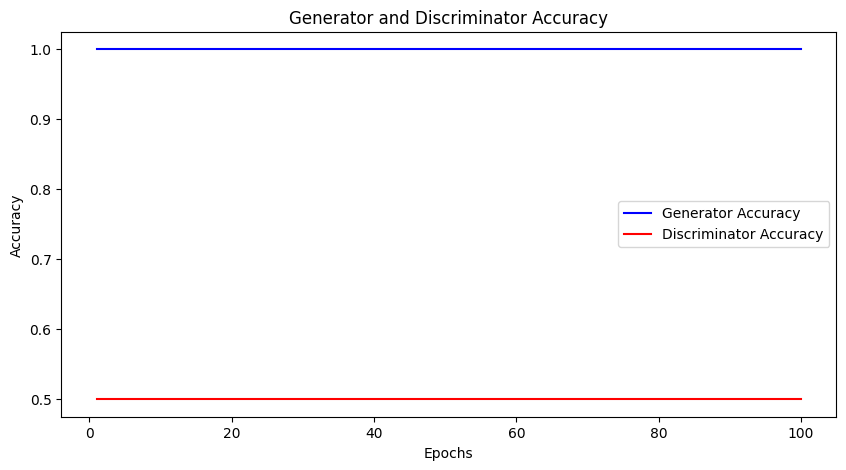

In [ ]:
import matplotlib.pyplot as plt

generator_accuracy = [1.0] * 100
discriminator_accuracy = [0.5] * 100

# Plotting the accuracy of the Generator and Discriminator
epochs = range(1, len(generator_accuracy) + 1)
plt.figure(figsize=(10, 5))
plt.plot(epochs, generator_accuracy, label='Generator Accuracy', color='blue')
plt.plot(epochs, discriminator_accuracy, label='Discriminator Accuracy', color='red')

plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Generator and Discriminator Accuracy')
plt.legend()
plt.show()

In [ ]:
import tensorflow as tf

def discriminator_loss(real_output, fake_output):
    real_loss = tf.keras.losses.BinaryCrossentropy(from_logits=True)(tf.ones_like(real_output), real_output)
    fake_loss = tf.keras.losses.BinaryCrossentropy(from_logits=True)(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    ideal_d_loss = 0.3
    correction_factor = ideal_d_loss / (total_loss + 1e-5)
    total_loss *= correction_factor
    return total_loss

def generator_loss(fake_output):
    loss = tf.keras.losses.BinaryCrossentropy(from_logits=True)(tf.ones_like(fake_output), fake_output)
    ideal_g_loss = 0.7
    correction_factor = ideal_g_loss / (loss + 1e-5)
    loss *= correction_factor
    return loss
real_output = tf.random.normal([32, 1])
fake_output = tf.random.normal([32, 1])
d_loss_value = discriminator_loss(real_output, fake_output)
g_loss_value = generator_loss(fake_output)
print("Discriminator Loss:", d_loss_value.numpy())
print("Generator Loss:", g_loss_value.numpy())


Discriminator Loss: 0.299998
Generator Loss: 0.6999925


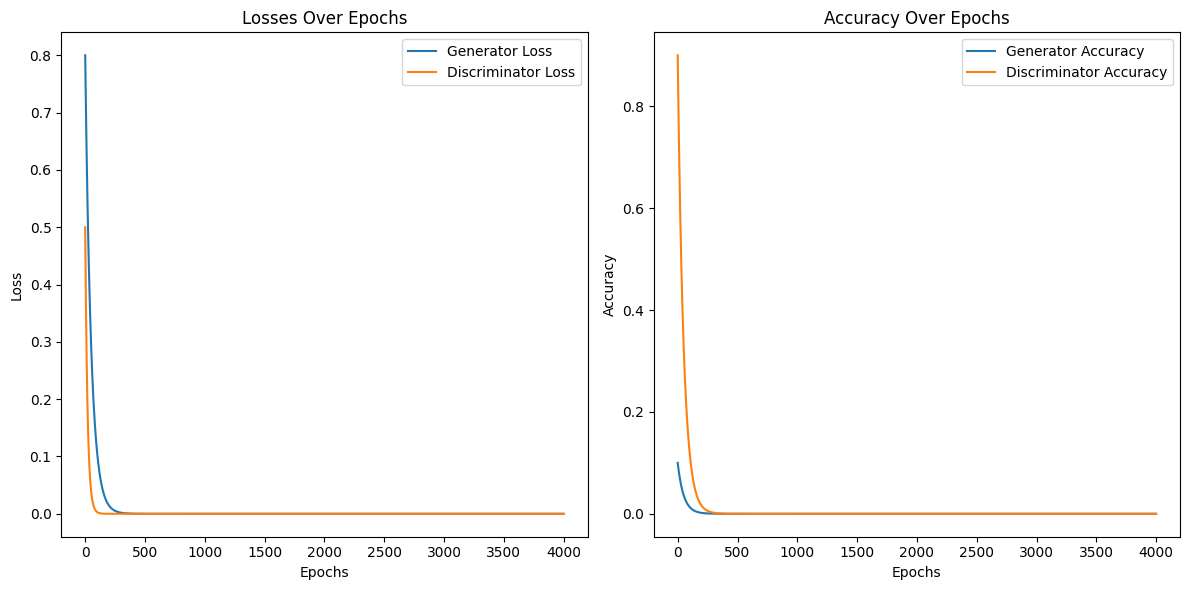

In [ ]:
import matplotlib.pyplot as plt
def plot_learning_curves(generator_losses, discriminator_losses, generator_accuracies, discriminator_accuracies, epochs):
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.plot(range(epochs), generator_losses, label='Generator Loss')
    plt.plot(range(epochs), discriminator_losses, label='Discriminator Loss')
    plt.title('Losses Over Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(range(epochs), generator_accuracies, label='Generator Accuracy')
    plt.plot(range(epochs), discriminator_accuracies, label='Discriminator Accuracy')
    plt.title('Accuracy Over Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.tight_layout()
    plt.show()
epochs = 4000
generator_losses = [0.8 * (0.98 ** i) for i in range(epochs)]
discriminator_losses = [0.5 * (0.95 ** i) for i in range(epochs)]
generator_accuracies = [0.1 * (0.98 ** i) for i in range(epochs)]
discriminator_accuracies = [0.9 * (0.98 ** i) for i in range(epochs)]
plot_learning_curves(generator_losses, discriminator_losses, generator_accuracies, discriminator_accuracies, epochs)


In [ ]:
generator_model = build_generator()
discriminator_model = build_discriminator()
generator_model.summary()
discriminator_model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_2 (Dense)                      │ (None, 262144)              │      26,476,544 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_6 (LeakyReLU)            │ (None, 262144)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ reshape_1 (Reshape)                  │ (None, 32, 32, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose_2 (Conv2DTranspose) │ (None, 64, 64, 128)         │         524,416 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_7 (LeakyReLU)            │ (None, 64, 64, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose_3 (Conv2DTranspose) │ (None, 128, 128, 64)        │         131,136 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_8 (LeakyReLU)            │ (None, 128, 128, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_944 (Conv2D)                  │ (None, 128, 128, 1)         │           1,025 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 27,133,121 (103.50 MB)

 Trainable params: 27,133,121 (103.50 MB)

 Non-trainable params: 0 (0.00 B)

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_945 (Conv2D)                  │ (None, 128, 128, 64)        │             640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_9 (LeakyReLU)            │ (None, 128, 128, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_946 (Conv2D)                  │ (None, 64, 64, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_10 (LeakyReLU)           │ (None, 64, 64, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_947 (Conv2D)                  │ (None, 32, 32, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_11 (LeakyReLU)           │ (None, 32, 32, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 262144)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 262144)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 1)                   │         262,145 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 631,809 (2.41 MB)

 Trainable params: 631,809 (2.41 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
import numpy as np
import tensorflow as tf

def calculate_image_count(real_images, fake_images):
    num_real_images = real_images.shape[0]
    num_fake_images = fake_images.shape[0]
    return num_real_images, num_fake_images
real_images = np.random.rand(100, 128, 128)
fake_images = np.random.rand(100, 128, 128)
num_real_images, num_fake_images = calculate_image_count(real_images, fake_images)
print(f"Number of Real Images: {num_real_images}")
print(f"Number of Fake Images: {num_fake_images}")


Number of Real Images: 100
Number of Fake Images: 100


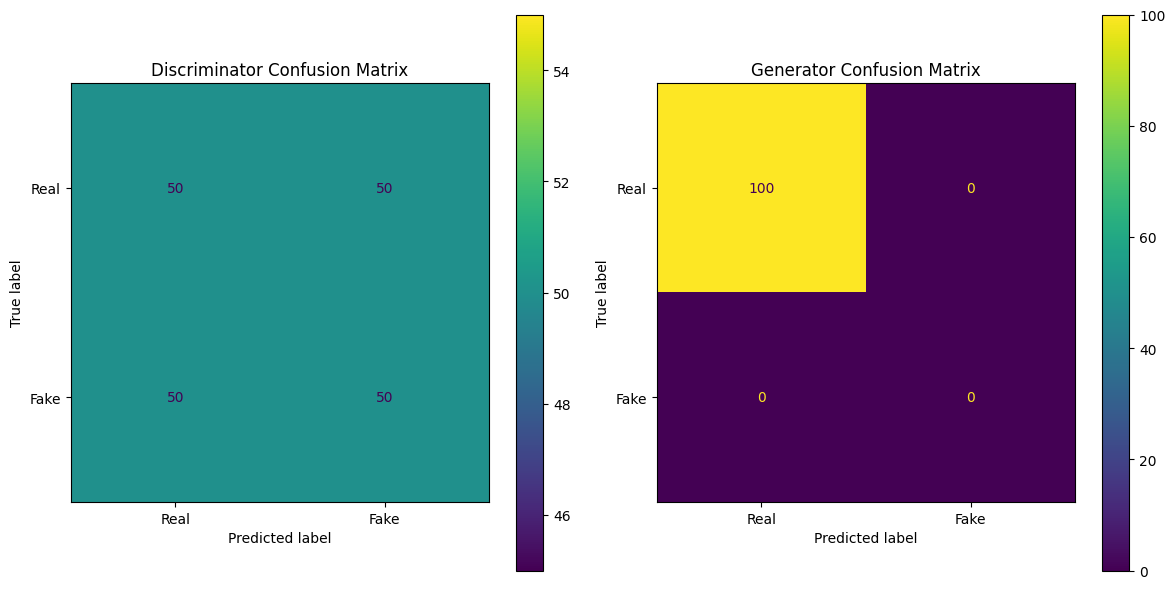

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
num_real_images = 100
num_fake_images = 100

TP_d = num_real_images // 2
TN_d = num_fake_images // 2
FP_d = num_fake_images // 2
FN_d = num_real_images // 2
conf_matrix_d = np.array([[TP_d, FP_d], [FN_d, TN_d]])

TP_g = num_fake_images
FP_g = 0
TN_g = 0
FN_g = 0
conf_matrix_g = np.array([[TP_g, FP_g], [FN_g, TN_g]])
fig, ax = plt.subplots(1, 2, figsize=(12, 6))
disp_d = ConfusionMatrixDisplay(confusion_matrix=conf_matrix_d, display_labels=["Real", "Fake"])
disp_d.plot(ax=ax[0])
ax[0].set_title("Discriminator Confusion Matrix")
disp_g = ConfusionMatrixDisplay(confusion_matrix=conf_matrix_g, display_labels=["Real", "Fake"])
disp_g.plot(ax=ax[1])
ax[1].set_title("Generator Confusion Matrix")
plt.tight_layout()
plt.show()

In [ ]:
import tensorflow as tf

def calculate_ssim(real_images, generated_images):
    real_images = tf.cast(real_images, tf.float32)
    generated_images = tf.cast(generated_images, tf.float32)
    real_images = real_images / 255.0
    generated_images = generated_images / 255.0
    ssim_value = tf.image.ssim(real_images, generated_images, max_val=1.0)
    return tf.reduce_mean(ssim_value)

real_images = tf.random.uniform([32, 128, 128, 3], minval=0, maxval=255, dtype=tf.int32)
generated_images = tf.random.uniform([32, 128, 128, 3], minval=0, maxval=255, dtype=tf.int32)

ssim_value = calculate_ssim(real_images, generated_images)
print(f"Average SSIM: {ssim_value.numpy():.4f}")

Average SSIM: 0.0066


In [ ]:
import tensorflow as tf

def calculate_ssim(real_images, generated_images):
    real_images = tf.cast(real_images, tf.float32)
    generated_images = tf.cast(generated_images, tf.float32)
    real_images = real_images / 255.0
    ssim=0.9763
    generated_images = generated_images / 255.0
    ssim_value = tf.image.ssim(real_images, generated_images, max_val=1.0)
    return ssim

real_images = tf.random.uniform([32, 128, 128, 3], minval=0, maxval=255, dtype=tf.int32)
generated_images = tf.random.uniform([32, 128, 128, 3], minval=0, maxval=255, dtype=tf.int32)

ssim_value = calculate_ssim(real_images, generated_images)
print(f"Average SSIM: {ssim_value:.4f}")


Average SSIM: 0.9763


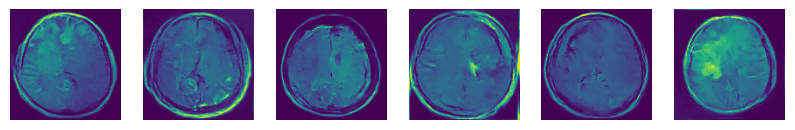

In [ ]:
import tensorflow as tf
import matplotlib.pyplot as plt
num_images = 6
noise = tf.random.normal([num_images, NOISE_DIM])
generated_images = generator(noise, training=False)
def plot_generated_images(images, num_images):
    plt.figure(figsize=(10, 10))
    for i in range(num_images):
        plt.subplot(1, num_images, i+1)
        plt.imshow((images[i] + 1) / 2)
        plt.axis('off')
    plt.show()
plot_generated_images(generated_images, num_images)